# ***Predict Restaurant Ratings***

In [41]:
### Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from autoviz.AutoViz_Class import AutoViz_Class
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [1]:
!pip install autoviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [3]:
## Load DataSet
df = pd.read_csv('/content/sample_data/Dataset .csv')


 ## **EDA**

In [35]:
### display bassic information about dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cuisines              9551 non-null   object 
 1   Average Cost for two  9551 non-null   int64  
 2   Currency              9551 non-null   object 
 3   Has Table booking     9551 non-null   object 
 4   Has Online delivery   9551 non-null   object 
 5   Is delivering now     9551 non-null   object 
 6   Switch to order menu  9551 non-null   object 
 7   Price range           9551 non-null   int64  
 8   Aggregate rating      9551 non-null   float64
 9   Votes                 9551 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 746.3+ KB


,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Votes
0,"French, Japanese, Desserts",1100,Botswana Pula(P),Yes,No,No,No,3,4.8,314
1,Japanese,1200,Botswana Pula(P),Yes,No,No,No,3,4.5,591
2,"Seafood, Asian, Filipino, Indian",4000,Botswana Pula(P),Yes,No,No,No,4,4.4,270
3,"Japanese, Sushi",1500,Botswana Pula(P),No,No,No,No,4,4.9,365
4,"Japanese, Korean",1500,Botswana Pula(P),Yes,No,No,No,4,4.8,229


<Figure size 1000x600 with 0 Axes>

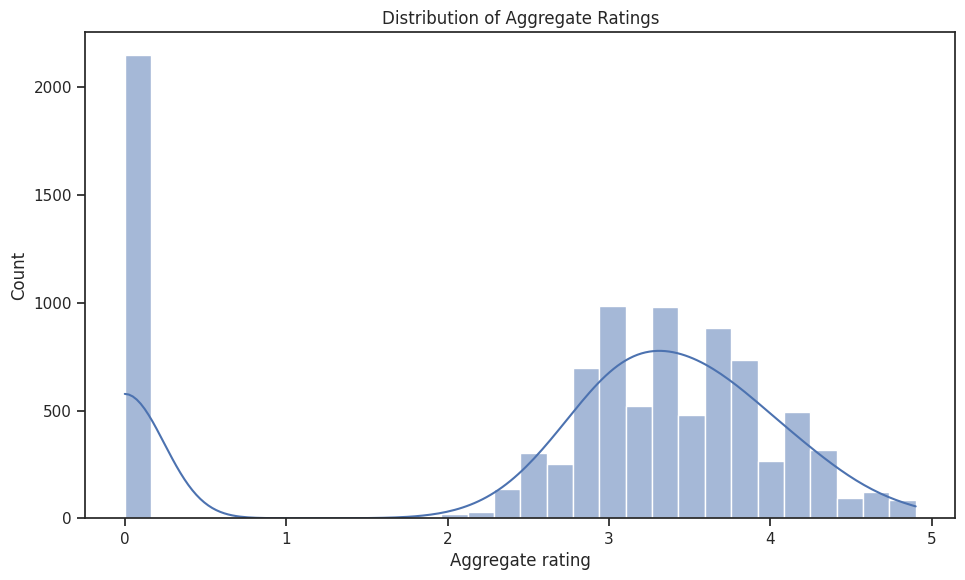

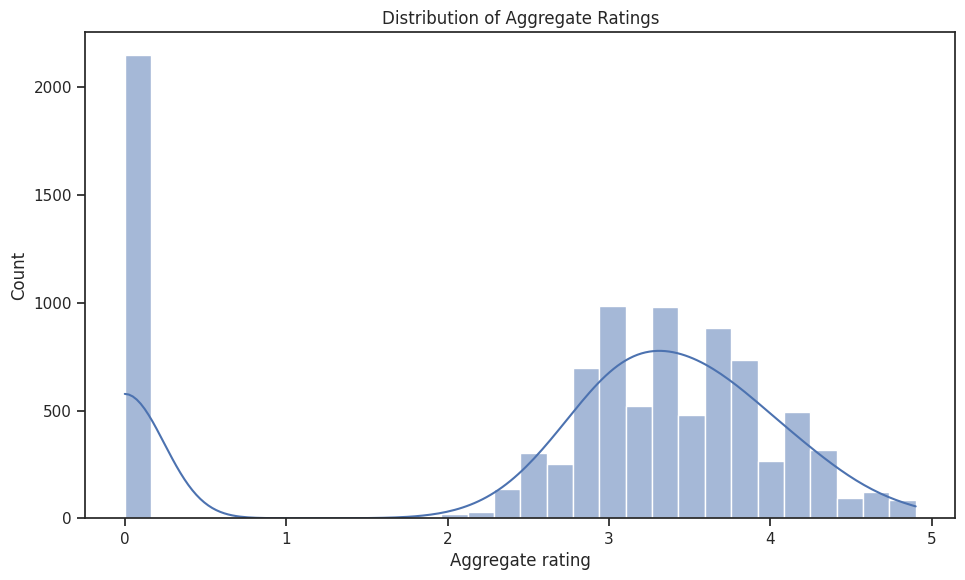

In [42]:
## Target Variable Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Aggregate rating'], kde=True, bins=30)
plt.title('Distribution of Aggregate Ratings')
plt.show()

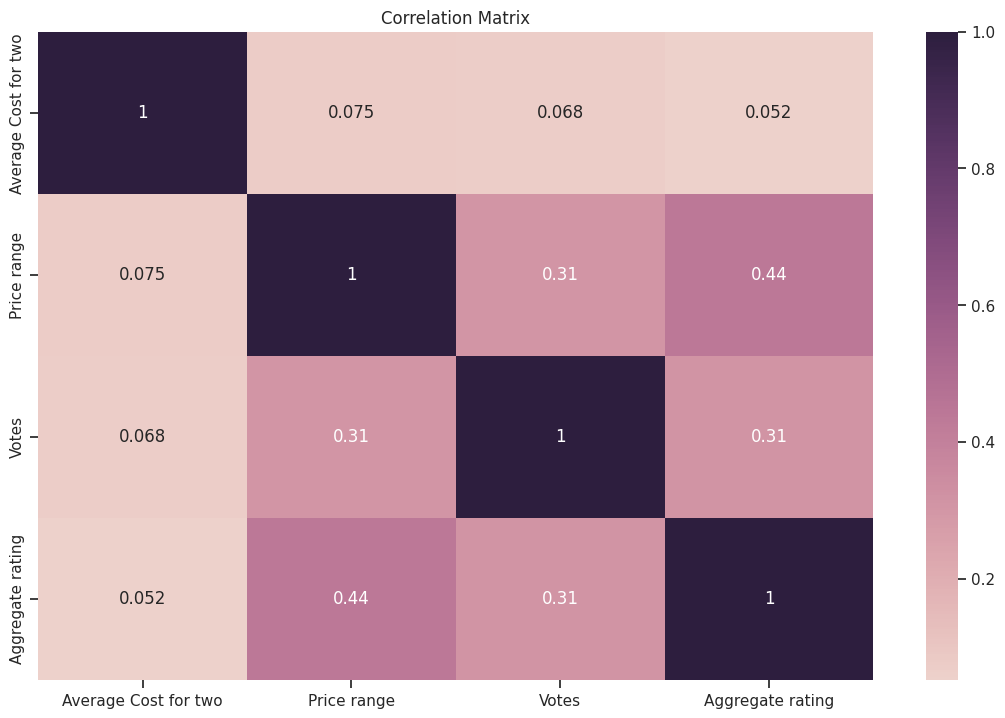

In [45]:
## Correlation Matrix
plt.figure(figsize=(12, 8))
numeric_cols = ['Average Cost for two', 'Price range', 'Votes', 'Aggregate rating']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Correlation Matrix')
plt.show()

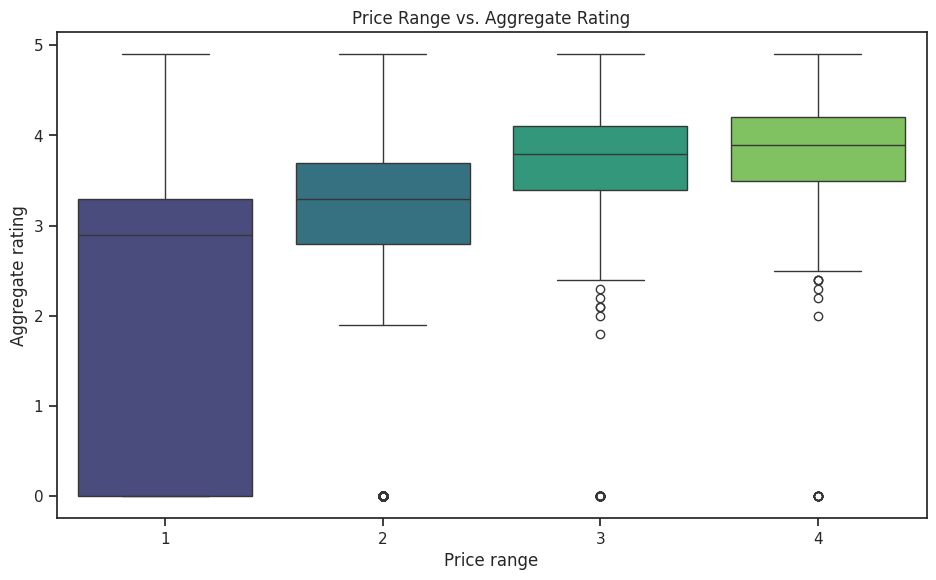

In [47]:
## Price Range Impact
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Price range', y='Aggregate rating', palette='viridis')
plt.title('Price Range vs. Aggregate Rating')
plt.show()

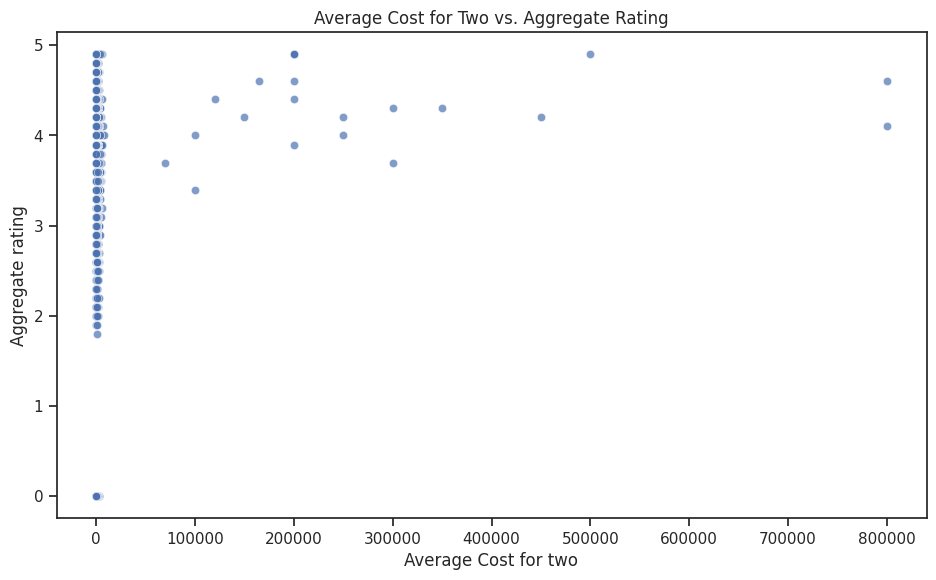

In [50]:
## Cost vs. Rating Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Average Cost for two', y='Aggregate rating', alpha=0.7)
plt.title('Average Cost for Two vs. Aggregate Rating')
plt.show()

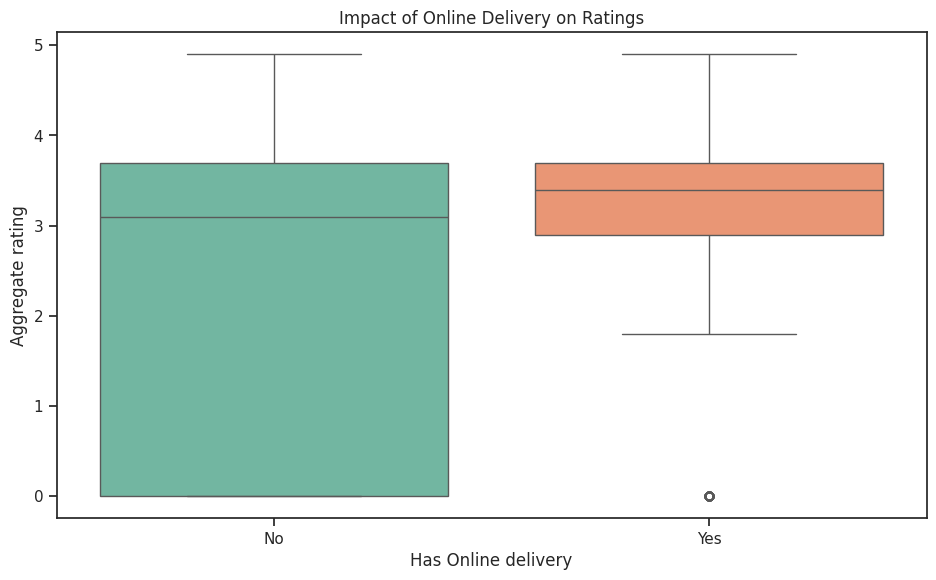

In [56]:
## Boolean Features Impact
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Has Online delivery', y='Aggregate rating', palette='Set2')
plt.title('Impact of Online Delivery on Ratings')
plt.show()



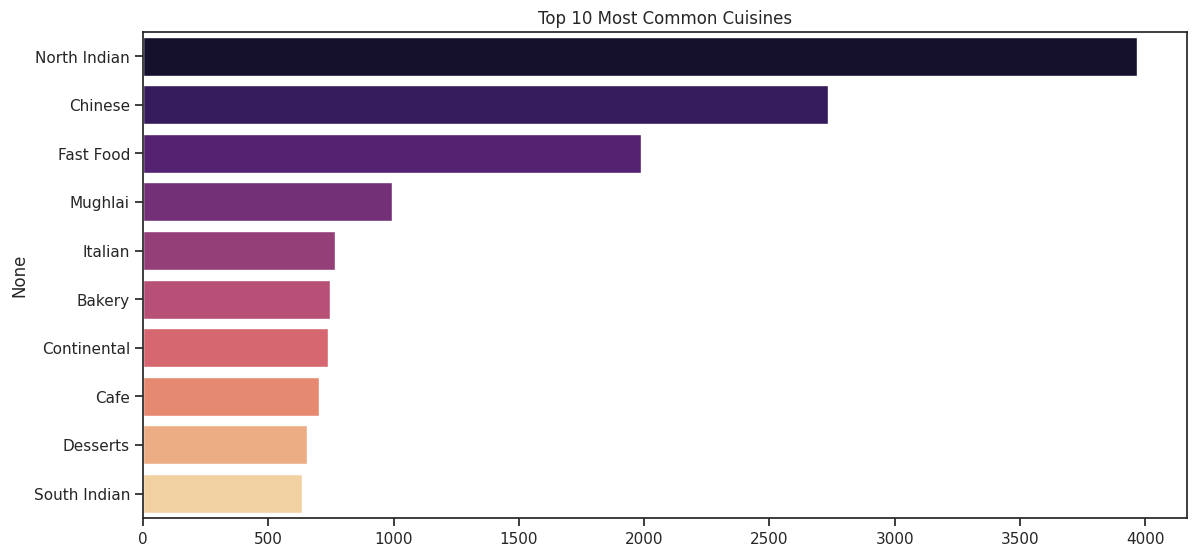

In [52]:
## Cuisine Analysis
cuisines = df['Cuisines'].str.split(', ', expand=True).stack().value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=cuisines.values, y=cuisines.index, palette='magma')
plt.title('Top 10 Most Common Cuisines')
plt.show()

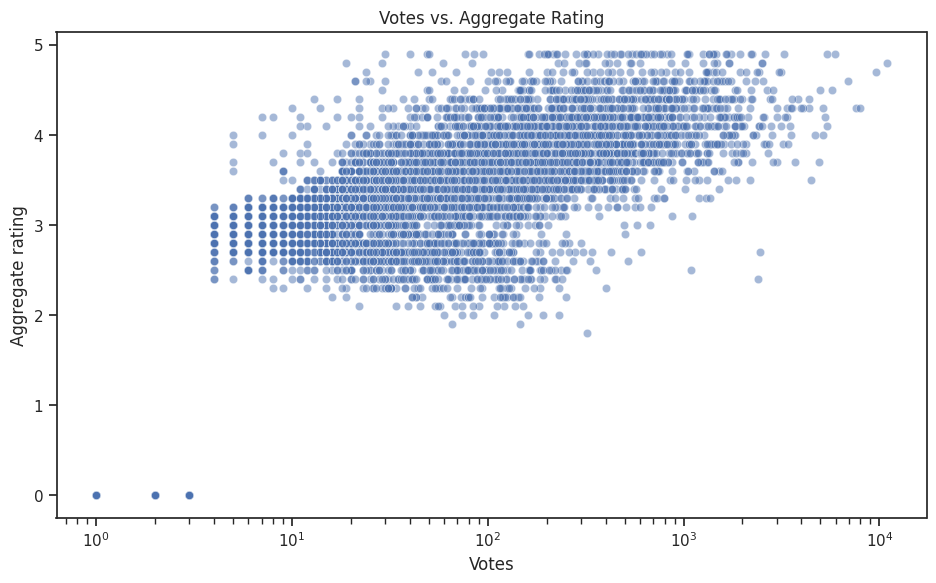

In [54]:
##Votes vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Votes', y='Aggregate rating', alpha=0.5)
plt.xscale('log')
plt.title('Votes vs. Aggregate Rating')
plt.show()

In [5]:
### Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64


## **Data Processing**

In [6]:
# Handle missing values, fill missing values with mean for numeric columns
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].mean(), inplace=True)

# For categorical columns, fill missing values with the mode
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [7]:
# Remove irrelevant features
irrelevant_features = ['Restaurant ID', 'Restaurant Name', 'Address','Country Code','City','Locality', 'Locality Verbose','Longitude','Latitude', 'Rating color','Rating text']
df = df.drop(columns=irrelevant_features)

In [8]:
# Define features and target variable

X = df.drop('Aggregate rating', axis=1)
y = df['Aggregate rating']

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)

In [10]:
# Preprocess numeric features
numeric_features = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_test_numeric = scaler.transform(X_test[numeric_features])

In [11]:
# Preprocess categorical features
categorical_features = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_categorical = encoder.fit_transform(X_train[categorical_features])
X_test_categorical = encoder.transform(X_test[categorical_features])

In [12]:
# Combine preprocessed features
X_train = np.hstack((X_train_numeric, X_train_categorical))
X_test = np.hstack((X_test_numeric, X_test_categorical))

## **Train and Evalute Model**

In [13]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### **Linear Regression**

In [14]:

prr_model = LinearRegression()
prr_model.fit(X_train_pca, y_train)

LinearRegression()

In [15]:
score = cross_val_score(prr_model, X_train_pca, y_train, cv=5, scoring='r2')
print("\nPRR Model Cross-Validation R-squared Scores:", score)
print("Mean CV R-squared:", np.mean(score))


PRR Model Cross-Validation R-squared Scores: [0.31273511 0.30986587 0.34056875 0.31909113 0.33140558]
Mean CV R-squared: 0.3227332875260511


In [ ]:
## too bad result of the above model.Negative sign indicates it and also the magnitude of the Mean CV R-squared tells us its bad ,then I removed irrevelent features and did PCA

In [16]:
prr_model_pred = prr_model.predict(X_test_pca)

In [17]:
prr_model_pred

array([1.4188023 , 3.3667475 , 2.43869391, ..., 3.08281697, 1.82803771,
       2.71298205])

In [18]:
mse_prr = mean_squared_error(y_test, prr_model_pred)
r2_prr = r2_score(y_test, prr_model_pred)
print("\nPRR Model:")
print(f"Mean Squared Error: {mse_prr}")
print(f"R-squared: {r2_prr}")


PRR Model:
Mean Squared Error: 1.5124260163596166
R-squared: 0.33570441196440604


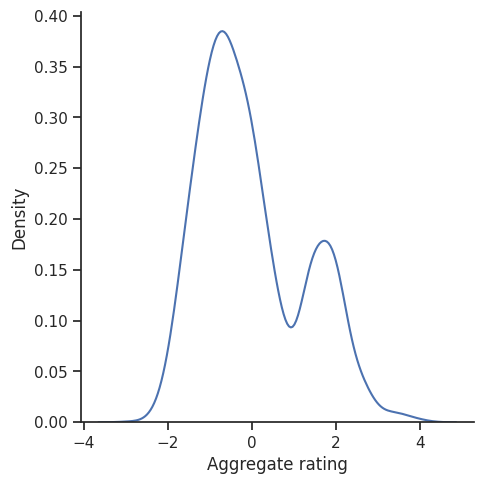

In [57]:
import seaborn as sns
sns.displot(prr_model_pred - y_test,kind = 'kde')
plt.show()


### **Elastic Net Linear Regression**

In [19]:
## to increase accuracy of model train and evaluate Elastic Net model with hyperparameter tuning

elastic_net_param_grid = {
    'alpha': [0.1, 1, 10, 100],
    'l1_ratio': [0.2, 0.5, 0.8]
}

In [20]:
grid_search_elastic_net = GridSearchCV(ElasticNet(max_iter=10000), elastic_net_param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_elastic_net.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10, 100],
                         'l1_ratio': [0.2, 0.5, 0.8]},
             scoring='r2')

In [21]:
best_elastic_net_model = grid_search_elastic_net.best_estimator_
print(grid_search_elastic_net.best_params_)

{'alpha': 0.1, 'l1_ratio': 0.2}


In [22]:
# Evaluate the best Elastic Net model
y_pred_elastic_net = best_elastic_net_model.predict(X_test_pca)

In [23]:
y_pred_elastic_net

array([1.79696077, 3.05903114, 2.53221587, ..., 2.68822257, 2.00677307,
       3.03686581])

In [24]:
mse_elastic_net = mean_squared_error(y_test, y_pred_elastic_net)
r2_elastic_net = r2_score(y_test, y_pred_elastic_net)
print("\nElastic Net Regression:")
print(f"Mean Squared Error: {mse_elastic_net}")
print(f"R-squared: {r2_elastic_net}")


Elastic Net Regression:
Mean Squared Error: 1.6158178993826522
R-squared: 0.2902920936176131


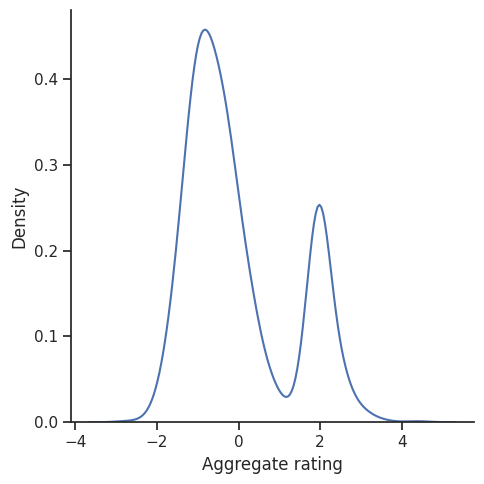

In [58]:
sns.displot(y_pred_elastic_net - y_test,kind = 'kde')
plt.show()

### **Decision Tree Regressor**

In [25]:
# Train and evaluate Decision Tree Regressor with hyperparameter tuning
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [26]:
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [27]:
best_dt = grid_dt.best_estimator_
print("\nBest parameters for Decision Tree Regression:")
print(grid_dt.best_params_)


Best parameters for Decision Tree Regression:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [28]:
y_pred_dt = best_dt.predict(X_test)
y_pred_dt

array([3.1388203 , 3.23406593, 3.1388203 , ..., 3.81674312, 2.99957717,
       3.1388203 ])

In [29]:
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print("\nDecision Tree Regression:")
print(f"Mean Squared Error: {mse_dt}")
print(f"R-squared: {r2_dt}")


Decision Tree Regression:
Mean Squared Error: 0.11649167575547087
R-squared: 0.9488339228430516


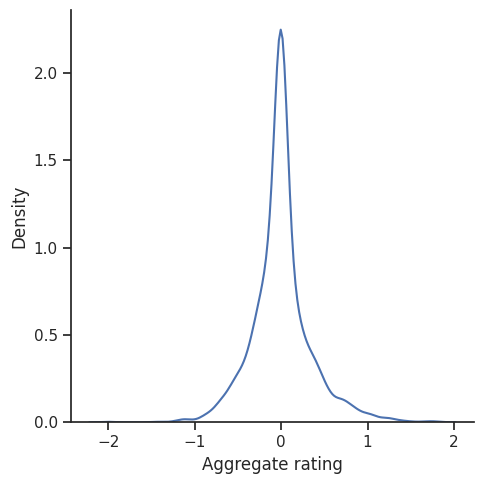

In [59]:
sns.displot(y_pred_dt - y_test,kind = 'kde')
plt.show()

### **Random Forest Regressor**

In [30]:
# Train and evaluate Random Forest Regressor with hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

In [31]:
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [32]:
best_rf = grid_rf.best_estimator_
print("\nBest parameters for Random Forest Regression:")
print(grid_rf.best_params_)


Best parameters for Random Forest Regression:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [33]:
y_pred_rf = best_rf.predict(X_test)
y_pred_rf

array([3.27578082, 3.46390746, 3.13070856, ..., 3.52985722, 2.90765357,
       2.80217136])

In [34]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("\nRandom Forest Regression:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R-squared: {r2_rf}")


Random Forest Regression:
Mean Squared Error: 0.1216047370620497
R-squared: 0.9465881375744992


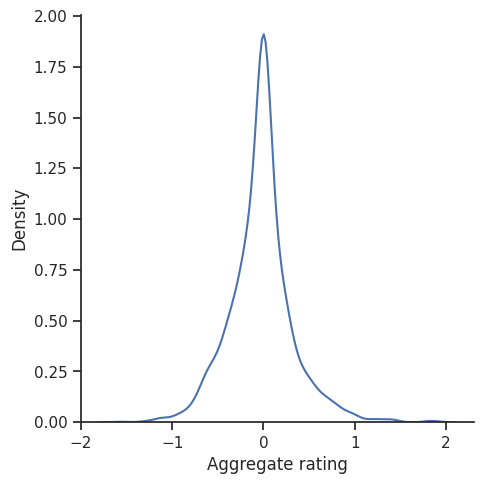

In [60]:
sns.displot(y_pred_rf - y_test,kind = 'kde')
plt.show()